In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import torchvision
from PIL import Image


# Group Equivariance Tutorial for Convolutional Neural Networks

This tutorial demonstrates how to build a group-equivariant convolutional neural network (GCNN) and compares its performance with a simple CNN on the MNIST dataset. GCNNs are a generalization of traditional convolutional neural networks (CNNs) that enforce equivariance to symmetry groups, leading to better performance and data efficiency. 

## Outline
1. **[Group Theory Background](#group-theory-background)**
    - Implement the Group C4
    - Implement the group action on functions 
    - First rotation equivariant convolution layer 
1. **[Build a Simple CNN](#build-a-simple-cnn)**
    - Define the SimpleCNN architecture
    - Implement functions for training and evaluating the model 
    - Prepare the MNIST dataset for training and testing
4. **[Train and Test SimpleCNN](#train-and-test-simplecnn)**
    - Train SimpleCNN on the MNIST dataset
    - Evaluate the model on the testing set
5. **[Demonstrate Equivariance](#demonstrate-translation-equivariance)**
    - Apply shifts to images and test the trained model's predictions
    - Rotate images and observe the trained model's performance
7. **[Group Equivariant CNN (GCNN)](#introduce-group-equivariant-cnn-gcnn)**
    - Define the GCNN architecture
    - Implement group-equivariant layers and operations
8. **[Compare GCNN Performance with Simple CNN](#compare-g-cnn-performance-with-simple-cnn)**
    - Train and evaluate the GCNN model on the MNIST dataset
    - Compare the performance of GCNN and SimpleCNN



# Group Theory Background

### Implement the Group $C_4$

Consider the group $G$ of rotations by multiples of $\frac{\pi}{2}$.
This group contains $4$ elements and is called the cyclic group of order $4$; we usually indicate it with $G=C_4$:


- The set of group elements of $C_4$ is given by $G:=\left\{e, g, g^2, g^3\right\}$. We can parameterise these group elements using rotation angles $\theta$, i.e. $e=$ $0, g=\frac{1}{2} \pi, g^2=\pi, \ldots$
- The group product is then given by $g \cdot g^{\prime}:=\theta+\theta^{\prime} \bmod 2 \pi$.
- The inverse is given by: $g^{-1}=-\theta \bmod 2 \pi$.
- The group $C_4$ has an action on the euclidean plane in 2 dimensions $\mathbb{R}^2$ given by a rotation matrix;
$$
R_\theta:\left[\begin{array}{cc}
\cos (\theta) & -\sin (\theta) \\
\sin (\theta) & \cos (\theta)
\end{array}\right]
$$

Note that we can identify the elements of $C_4$ with the integers *modulo* $4$
$$
  C_4 = \{R_{0}, R_{\frac{\pi}{2}}, R_{\pi}, R_{3\frac{\pi}{2}} \} = \{ R_{r \frac{\pi}{2}} \ |\ r = 0, 1, 2, 3\}
$$
$$
  R_{r \frac{\pi}{2}} \cdot R_{s \frac{\pi}{2}} = R_{(r + s \mod 4) \frac{\pi}{2}}
$$

In [2]:
class C4:
  
  @staticmethod
  def _check_valid_input(r: int) -> None:
      if not isinstance(r, int) or r < 0 or r > 3:
          raise ValueError("Input must be an integer between 0 and 3, inclusive.")


  @staticmethod
  def product(r: int, s: int) -> int:
    # Implements the *group law* of the group C_4.
    # The input `r` and `s` must be integers in {0, 1, 2, 3} and represent two elements of the group.
    # The method should return the integer representing the product of the two input elements.
    C4._check_valid_input(r)
    C4._check_valid_input(s)
    return (r + s) % 4

  
  @staticmethod
  def inverse(r: int) -> int:
    # Implements the *inverse* operation of the group C_4.
    # The input `r` must be an integer in {0, 1, 2, 3} and represents an element of the group.
   C4._check_valid_input(r)
   return (-r) % 4


The product method takes two input integers r and s, checks if they are valid elements of the group (i.e., integers in the range 0 to 3, inclusive), and then calculates the product of the two elements according to the group operation. In this case, the group operation is modular addition modulo 4, which is (r + s) % 4.

The inverse method calculates the inverse of an element of the group. The inverse of an element r is an element s such that their product, according to the group operation, equals the identity element of the group (which, in the case of C4, is 0). For C4, the inverse of r can be computed as the modular negation of r modulo 4, which is (-r) % 4

In [3]:
# Some test cases to check if your implementation is working
assert C4.product(1, 3) == 0 #90 + 270 = 360 (identity)
assert C4.product(0, 0) == 0 #0 + 0 = 0 (identity)
assert C4.product(2, 3) == 1 
assert C4.inverse(0) == 0
assert C4.inverse(1) == 3 #this is the same as the first assertion 

### Implement the group action on functions 



Let's see an example.
Consider the group $G=C_4$ of planar rotations by multiples of $\frac{\pi}{2}$.
Let $X$ be the set of all $33 \times 33$ gray-scale images.
An image $x \in X$ is interpreted as a function $x: \mathbf{p} \mapsto x[\mathbf{p}] \in \mathbb{R}$ which maps each pixel (identified by its coordinates $\mathbf{p} = (h,w)$) to a real number.

An element $g = R_{r \frac{\pi}{2}} \in G$ transforms an image $x \in X$ into the image $g.x \in X$ through a counter-clockwise rotation by $r \frac{\pi}{2}$ radians.
The rotated image $g.x$ is defined on each pixel $\mathbf{p}$ as:
$$
 [g.x](\mathbf{p}) := x(g^{-1}.\mathbf{p})
$$
where $g^{-1}.\mathbf{p}$ is the pixel in the original image $x$ which is moved to the position $\mathbf{p}$ in the new image $g.x$.



In [3]:
def rotate(x: torch.Tensor, r: int) -> torch.Tensor:
  # Method which implements the action of the group element `g` indexed by `r` on the input image `x`.
  # The method returns the image `g.x`
  
  return x.rot90(r, dims=(-2, -1))

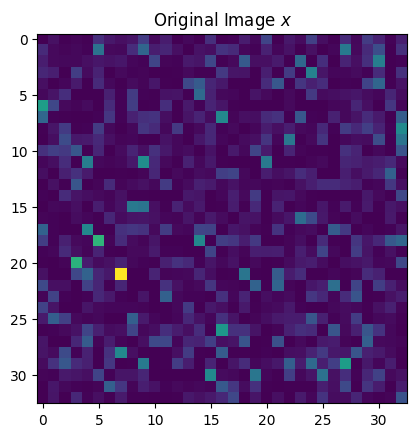

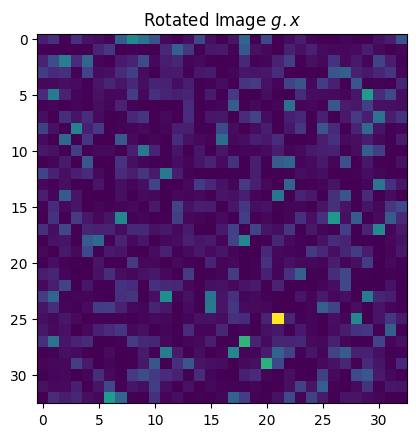

In [4]:
x = torch.randn(1, 1, 33, 33)**2

r = 1
gx = rotate(x, r)

plt.imshow(x[0, 0].numpy())
plt.title('Original Image $x$')
plt.show()

plt.imshow(gx[0, 0].numpy())
plt.title('Rotated Image $g.x$')
plt.show()

### First rotation equivariant convolution layer

Let's try now to build a rotation equivariant convolution layer.
An equivariant layer is a function $\psi: X \to Y$ from an input $G$-space $X$ to an output $G$-space $Y$.
We assume the input space is the space of images we defined before but we still need to choose an output space $Y$.
As a first example, we choose $Y = X$, i.e. the output is still a space of grayscale images.

Our equivariant layer will be a convolution with a $3 \times 3$ filter.
Note that the use of convolution guarantees the translation equivariance.
$$
g.\psi(x) = \psi(g.x)
$$

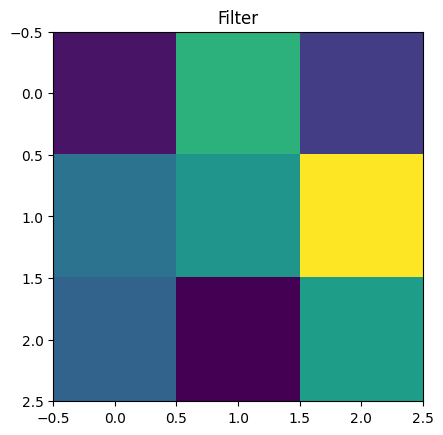

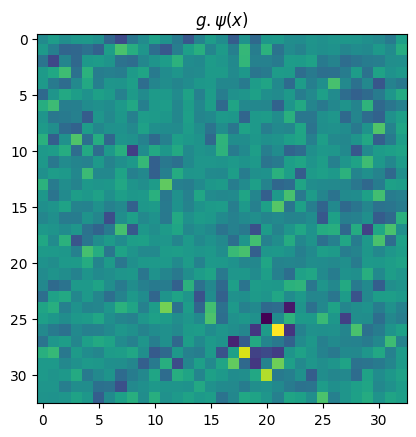

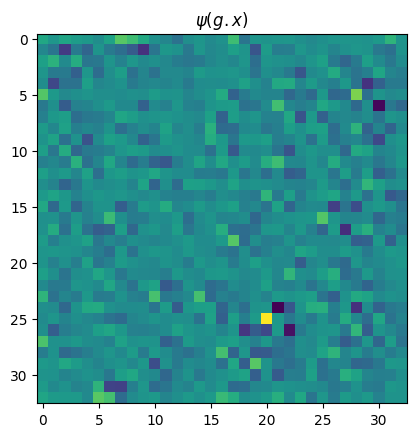

In [6]:
filter3x3 = torch.randn(1, 1, 3, 3)

plt.imshow(filter3x3[0, 0].numpy())
plt.title('Filter')
plt.show()


psi_x = torch.conv2d(x, filter3x3, bias=None, padding=1)
psi_gx = torch.conv2d(gx, filter3x3, bias=None, padding=1)

g_psi_x = rotate(psi_x, r)

plt.imshow(g_psi_x[0, 0].numpy())
plt.title('$g.\psi(x)$')
plt.show()

plt.imshow(psi_gx[0, 0].numpy())
plt.title('$\psi(g.x)$')
plt.show()

The two images do not look the same

To ensure that both outputs are the same, we can use an isotropic filter:

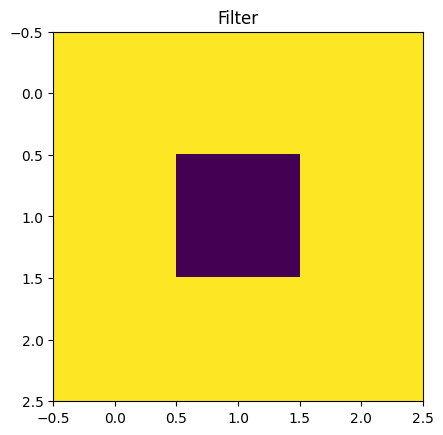

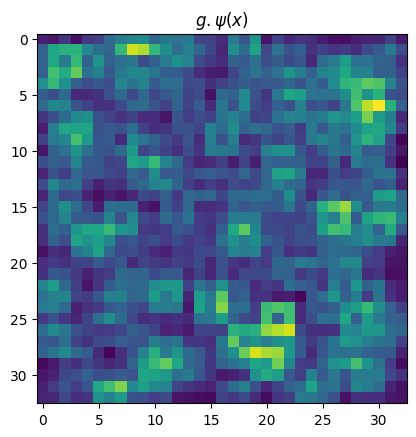

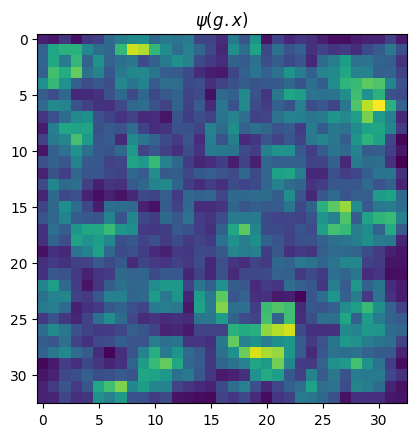

In [7]:
filter3x3 = torch.empty((1, 1, 3, 3))
# fill the central pixel
filter3x3[0, 0, 1, 1] = np.random.randn()
# fill the ring of radius 1 around it with a unique value
mask = torch.ones(3, 3, dtype=torch.bool)
mask[1, 1] = 0
filter3x3[0, 0, mask] = np.random.randn()

plt.imshow(filter3x3[0, 0].numpy())
plt.title('Filter')
plt.show()


psi_x = torch.conv2d(x, filter3x3, bias=None, padding=1)
psi_gx = torch.conv2d(gx, filter3x3, bias=None, padding=1)

g_psi_x = rotate(psi_x, r)

plt.imshow(g_psi_x[0, 0].numpy())
plt.title('$g.\psi(x)$')
plt.show()

plt.imshow(psi_gx[0, 0].numpy())
plt.title('$\psi(g.x)$')
plt.show()


With an isotropic filter, one may rotate the image and then perform a convolution or perform a convolution and then rotate the image, i.e., rotational equivariance 

# Build a Simple CNN
Here's a simple architecture for the MNIST dataset:

This architecture takes an input image with one channel (grayscale) and applies a series of convolutional, activation, and pooling layers to extract features from the image. The output of the last convolutional layer is flattened into a 1D tensor and fed into a fully connected layer that produces a probability distribution over the 10 possible classes.

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(32, 10) # 4 * 4 is the size of the feature map
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # apply convolutional layer, ReLU activation and max pooling
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 32) # flatten feature map to a 1D tensor
        x = self.fc(x) # apply fully connected layer
        return F.log_softmax(x, dim=1)


### Define Train and Evaluate Functions

In [9]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return running_loss / len(train_loader), 100. * correct / total

def evaluate(model, validation_loader, criterion, device):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in validation_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return running_loss / len(validation_loader), 100. * correct / total



### Load MNIST Data

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("device: ",device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)


device:  mps


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=32, out_features=10, bias=True)
)

# Train and Test Simple CNN

In [11]:
num_epochs = 10
if os.path.exists('pretrained_model.pt'):
    print("Loading pretrained weights...")
    model.load_state_dict(torch.load('pretrained_model.pt'))
else:
    # Train the model if no saved weights exist
    print("Training model...")
    num_epochs = 10
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        validation_loss, validation_acc = evaluate(model, validation_loader, criterion, device)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_acc:.2f}%")
    
    # Save the trained weights
    torch.save(model.state_dict(), 'pretrained_model.pt')

Loading pretrained weights...


# Demonstrate Translation Equivariance

We can demonstrate the property of translation equivariance by taking a test image of a digit and shifting it by a few pixels in any direction. If the network is translation equivariant, then it should still classify the shifted image the same as the original classification

Prediction for original test image: 7
Prediction for shifted test image: 7


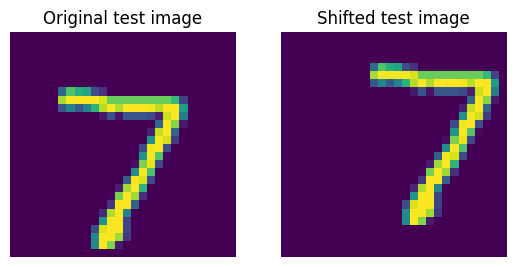

In [12]:

# Load a test image from the validation dataset
test_image = next(iter(validation_dataset))[0][0]

# Display the original test image
plt.subplot(1, 2, 1)
plt.imshow(test_image.squeeze(), cmap='viridis')
plt.title("Original test image")
plt.axis('off')

# Make a prediction for the original test image
with torch.no_grad():
    model.eval()
    test_image = test_image.unsqueeze(0).to(device)
    output = model(test_image)
    predicted_label = output.argmax(dim=1).item()
    print(f"Prediction for original test image: {predicted_label}")

# Shift the test image by a few pixels in the x and y directions
shifted_image = test_image.cpu().roll((-3, 5), dims=(1, 2))

# Display the shifted test image
plt.subplot(1, 2, 2)
plt.imshow(shifted_image.squeeze(), cmap='viridis')
plt.title("Shifted test image")
plt.axis('off')

# Make a prediction for the shifted test image
with torch.no_grad():
    model.eval()
    shifted_image = shifted_image.unsqueeze(0).to(device)
    output = model(shifted_image)
    predicted_label = output.argmax(dim=1).item()
    print(f"Prediction for shifted test image: {predicted_label}")

# Show the plot with both images
plt.show()


<p> Does not work 100% perfect accross all translations <span style="font-size: 50px;">&#x1F921;</span> but I'd say the performance is satisfactory <span style="font-size: 50px;">&#x1F642;</span> </p>


# Test Rotational Equivariance

Prediction for original test image: 1
Prediction for rotated test image: 7


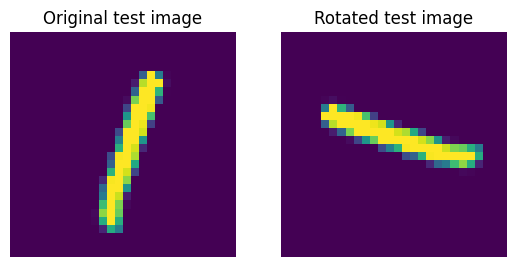

In [13]:
# Load a test image from the validation dataset
test_image = validation_dataset[5][0]

# Remove the extra dimension
test_image = test_image.squeeze()

# Display the original test image
plt.subplot(1, 2, 1)
plt.imshow(test_image, cmap='viridis')
plt.title("Original test image")
plt.axis('off')

# Make a prediction for the original test image
with torch.no_grad():
    model.eval()
    test_image = test_image.unsqueeze(0).unsqueeze(0).to(device)
    output = model(test_image)
    predicted_label = output.argmax(dim=1).item()
    print(f"Prediction for original test image: {predicted_label}")

# Rotate the test image by 30 degrees
rotated_image = transforms.functional.rotate(test_image.cpu(), 90)

# Remove the extra dimension
rotated_image = rotated_image.squeeze()

# Display the rotated test image
plt.subplot(1, 2, 2)
plt.imshow(rotated_image, cmap='viridis')
plt.title("Rotated test image")
plt.axis('off')

# Make a prediction for the rotated test image
with torch.no_grad():
    model.eval()
    rotated_image = rotated_image.unsqueeze(0).unsqueeze(0).to(device)
    output = model(rotated_image)
    predicted_label = output.argmax(dim=1).item()
    print(f"Prediction for rotated test image: {predicted_label}")

# Show the plot with both images
plt.show()


# Group Equivariant CNN (GCNN)

GCNNs are a type of neural network that enforce equivariance to symmetry groups, meaning that their activations transform in a predictable way under transformations of the input. To achieve this equivariance, GCNNs use group-equivariant convolutional layers and other group-equivariant operations, which enforce constraints on how the activations of the network transform under the symmetry group. In practice, G-CNNs can be designed to be equivariant to a wide range of symmetry groups, each with their own set of equivariance constraints. In this section, we will dive deeper into how GCNNs work, specifically for the cyclic group.

The ConvZ2P4 class defines a custom convolutional layer for group-equivariant CNNs, specifically designed for rotations in multiples of 90 degrees. It  takes an input tensor with Z2 symmetry (i.e., translation symmetry) and produces an output tensor with P4 symmetry (i.e., rotational and translation symmetries). This is achieved by rotating the weight tensor in multiples of 90 degrees and applying the convolution operation with each rotated weight tensor. The output feature maps obtained from each convolution are then combined along the channel dimension

Because this process essentially "lifts" the input from Z2 to P4 symmetry, the term "lifting convolution" is often used to describe this layer

In [18]:

class ConvZ2P4(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 bias=True, stride=1, padding=1):
        super().__init__()

        # Initialize weight tensor and apply Kaiming initialization
        w = torch.empty(out_channels, in_channels, kernel_size, kernel_size)
        self.weight = nn.Parameter(w)
        nn.init.kaiming_uniform_(self.weight, a=(5 ** 0.5))

        # Initialize bias tensor if bias is True
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channels))
        else:
            self.bias = None

        # Save stride and padding values
        self.stride = stride
        self.padding = padding

    # Helper function to perform the 4 rotations of the weight tensor
    def _rotated(self, w):
        ws = [torch.rot90(w, k, (2, 3)) for k in range(4)]
        return torch.cat(ws, 1).view(-1, w.size(1), w.size(2), w.size(3))

    # Forward pass function
    def forward(self, x):
        # Rotate the weight tensor and apply the convolution to each rotation
        w = self._rotated(self.weight)
        y = F.conv2d(x, w, stride=self.stride, padding=self.padding)

        # Reshape the output tensor to restore P4 symmetry
        y = y.view(y.size(0), -1, 4, y.size(2), y.size(3))

        # Add bias tensor if bias is not None
        if self.bias is not None:
            y = y + self.bias.view(1, -1, 1, 1, 1)

        return y



The ConvP4 layer is a group-equivariant convolutional layer for the P4 symmetry group.  The weight tensor is first rotated in four different ways (0, 90, 180, and 270 degrees), and these rotated versions are concatenated along the channel dimension before the convolution takes place. this works is because the input tensor is reshaped to have 4 times the number of input channels, which effectively incorporates the information from all four rotations. When the convolution operation is applied to this reshaped tensor using the rotated weight tensor, the output tensor implicitly contains the results of convolutions applied to all four rotated versions of the input tensor.

In [19]:

class ConvP4(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 bias=True, stride=1, padding=1):
        super().__init__()
        
        # Initialize weight tensor and apply Kaiming initialization
        w = torch.empty(out_channels, in_channels, 4, kernel_size, kernel_size)
        self.weight = torch.nn.Parameter(w)
        torch.nn.init.kaiming_uniform_(self.weight, a=(5 ** 0.5))
        
        # Initialize bias tensor if bias is True
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(out_channels))
        else:
            self.bias = None
        
        # Save stride and padding values
        self.stride = stride
        self.padding = padding

    # Helper function to perform the 4 rotations of the weight tensor
    def _rotated(self, w):
        # Apply 4 rotations to the weight tensor
        ws = [_grot90(w, k).view(w.size(0), -1, w.size(3), w.size(4)) for k in range(4)]
        # Concatenate the rotated tensors along the channel dimension
        return torch.cat(ws, 1).view(4 * w.size(0), 4 * w.size(1), w.size(3), w.size(4))

    def forward(self, x):
        # Reshape the input tensor to restore P4 symmetry
        x = x.view(x.size(0), -1, x.size(3), x.size(4))
        # Rotate the weight tensor and apply the convolution to each rotation
        w = self._rotated(self.weight)
        y = F.conv2d(x, w, stride=self.stride, padding=self.padding)
        # Reshape the output tensor to restore P4 symmetry
        y = y.view(y.size(0), -1, 4, y.size(2), y.size(3))
        # Add bias tensor if bias is not None
        if self.bias is not None:
            y = y + self.bias.view(1, -1, 1, 1, 1)
        return y



MaxRotationPoolP4: This layer computes the maximum value along the rotation axis (axis=2) of a tensor with P4 symmetry. It can be used to combine information from all four rotations after applying a group-equivariant convolution.

MaxSpatialPoolP4: This layer applies max pooling in the spatial dimensions (height and width) of a tensor with P4 symmetry. It first reshapes the input tensor, applies the MaxPool2d layer, and then reshapes the output tensor back to restore the P4 symmetry.

AvgRootPoolP4: This layer computes the average value along the rotation axis (axis=2) of a tensor with P4 symmetry. Similar to MaxRotationPoolP4, it can be used to combine information from all four rotations after a group-equivariant convolution.

_grot90: This is a helper function that rotates the input tensor by 90 degrees k times along the height and width dimensions while also rolling the tensor along the rotation axis (axis=2) by k steps. This function is used in the ConvP4 layer to prepare rotated versions of the weight tensor for the convolution operation.

In [20]:


class MaxRotationPoolP4(torch.nn.Module):
    def forward(self, x):
        # Compute the maximum value along the rotation axis (axis=2) of a tensor with P4 symmetry
        return x.max(2).values


class MaxSpatialPoolP4(torch.nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super().__init__()
        # Create a MaxPool2d layer with the given kernel size, stride, and padding
        self.inner = torch.nn.MaxPool2d(kernel_size, stride, padding)
    
    def forward(self, x):
        # Reshape the input tensor to (batch_size, channels * 4, height, width)
        y = x.view(x.size(0), -1, x.size(3), x.size(4))
        # Apply MaxPool2d to the reshaped tensor
        y = self.inner(y)
        # Reshape the output tensor to (batch_size, channels, 4, out_height, out_width)
        y = y.view(x.size(0), -1, 4, y.size(2), y.size(3))
        return y


class AvgRootPoolP4(torch.nn.Module):
    def forward(self, x):
        # Compute the average value along the rotation axis (axis=2) of a tensor with P4 symmetry
        return x.mean(2)

def _grot90(x, k):
    # Roll the input tensor along the rotation axis (axis=2) by k steps
    x_cpu = x.cpu()
    x_rolled = torch.roll(x_cpu, shifts=k, dims=2)
    # Rotate the rolled tensor by 90 degrees along the height and width dimensions
    x_rot90 = torch.rot90(x_rolled, k, (3, 4))
    return x_rot90.to(x.device)



Finally, GCNN starts with a ConvZ2P4 layer to lift the input image into the P4 symmetry space, followed by multiple ConvP4 layers to maintain the rotational symmetry throughout the network. The architecture also includes max spatial pooling layers for dimensionality reduction, and a final max rotation pooling layer to collapse the symmetry space. Lastly, a fully connected layer is used to produce the output logits, which are then transformed into probabilities using a log-softmax function. GCNN essentially mirrors SimpleCNN in look with the exception of reducing the hidden channgles to maintain approximately equivalent trainable parameters

In [21]:


class GCNN(torch.nn.Module):
    def __init__(self):
        super(GCNN, self).__init__()

        self.conv1 = ConvZ2P4(1, 16, 5)
        self.conv2 = ConvP4(16, 16, 3)
        self.conv3 = ConvP4(16, 16, 3)
        self.conv4 = ConvP4(16, 16, 3)
        self.pool1 = MaxSpatialPoolP4(2)
        self.pool2 = MaxSpatialPoolP4(2)
        self.pool3 = MaxSpatialPoolP4(2)
        self.pool4 = MaxRotationPoolP4()
        self.pool5 = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(16, 10)

    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))
        x = F.relu(self.pool3(self.conv3(x)))
        x = F.relu(self.pool4(self.conv4(x)))
        x = self.pool5(x)
        x = x.squeeze(-1).squeeze(-1)
        x = self.fc(x)
        output = F.log_softmax(x, dim=1)
        return output



# Compare G-CNN Performance with Simple CNN
Here we load on original MNIST set for training and randomly rotate test set from 0-360 degrees

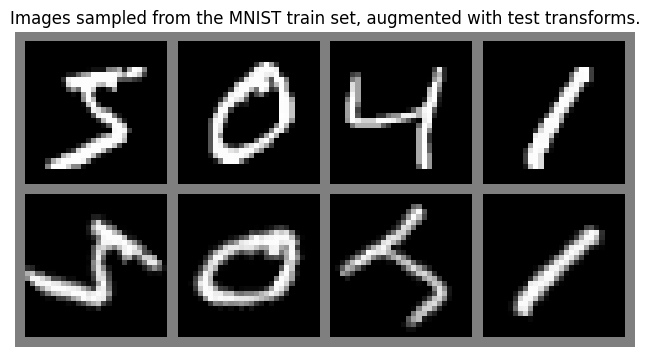

In [22]:


torch.manual_seed(42)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation([0, 360],transforms.InterpolationMode.BILINEAR,fill=0),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

NUM_IMAGES = 4
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_dataset.data[idx].numpy()) for idx in range(NUM_IMAGES)]
orig_images = [transform(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Images sampled from the MNIST train set, augmented with test transforms.")
plt.imshow(img_grid,cmap='viridis')
plt.axis('off')
plt.show()
plt.close()


Test GCNN. Note: we still make use of same training and evaluation functions

In [23]:
model = GCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)
num_epochs = 3

if os.path.exists('gcnn_model.pt'):
    print("Loading pretrained weights...")
    model.load_state_dict(torch.load('gcnn_model.pt'))
    validation_loss, validation_acc = evaluate(model, validation_loader, criterion, device)
else:
    # Train the model if no saved weights exist
    print("Training model...")
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        validation_loss, validation_acc = evaluate(model, validation_loader, criterion, device)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_acc:.2f}%")
    
    # Save the trained weights
    torch.save(model.state_dict(), 'gcnn_model.pt')
    
gcnn_results = validation_acc
gcnn_model = model
gcnn_params = sum(p.numel() for p in gcnn_model.parameters() if p.requires_grad)

Loading pretrained weights...


Now test SimpleCNN

In [24]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)
if os.path.exists('cnn_model.pt'):
    print("Loading pretrained weights...")
    model.load_state_dict(torch.load('cnn_model.pt'))
    validation_loss, validation_acc = evaluate(model, validation_loader, criterion, device)
else:
    # Train the model if no saved weights exist
    print("Training model...")
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        validation_loss, validation_acc = evaluate(model, validation_loader, criterion, device)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_acc:.2f}%")
    
    # Save the trained weights
    torch.save(model.state_dict(), 'cnn_model.pt')
cnn_results = validation_acc
cnn_model = model
cnn_params = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)

Loading pretrained weights...


In [25]:
models = {
    "GCNN": {
        "accuracy": gcnn_results,
        "trainable_params": gcnn_params,
    },
    "CNN": {
        "accuracy": cnn_results,
        "trainable_params": cnn_params,
    }
}

# Print the table
print("Model\tAccuracy\tTrainable Params")
for model, values in models.items():
    print(f"{model}\t{values['accuracy']}\t{values['trainable_params']}")

Model	Accuracy	Trainable Params
GCNN	71.23	28282
CNN	41.31	28394


SimpleCNN <span style="font-size: 50px;">&#x1F62D;</span>

GCNN is not very good either. This is because we used all rotations from 0-360 degrees, but we designed our network to be equivariant to 90 degree rotations. We can see if we get better results by augmenting our test set to respect the symmetries we have assumed. 

In [26]:
torch.manual_seed(42)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

class RandomRotation90(transforms.RandomRotation):
    def __init__(self, degrees, resample=Image.BILINEAR, expand=False, center=None):
        super(RandomRotation90, self).__init__(degrees, resample, expand, center)

    def get_params(self, img):
        angle = math.floor(random.random() * 4) * 90
        return angle

transform = transforms.Compose([
                transforms.ToTensor(),
                RandomRotation90((0, 360), resample=transforms.InterpolationMode.BILINEAR),
                transforms.Normalize((0.1307,), (0.3081,))
            ])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

/var/folders/18/3kclsxgj3jj7mvx5j6cf7qtr0000gn/T/ipykernel_41479/823595054.py:9: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  def __init__(self, degrees, resample=Image.BILINEAR, expand=False, center=None):


In [27]:
model = GCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)
num_epochs = 3

if os.path.exists('gcnn_model2.pt'):
    print("Loading pretrained weights...")
    model.load_state_dict(torch.load('gcnn_model2.pt'))
    validation_loss, validation_acc = evaluate(model, validation_loader, criterion, device)
else:
    # Train the model if no saved weights exist
    print("Training model...")
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        validation_loss, validation_acc = evaluate(model, validation_loader, criterion, device)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_acc:.2f}%")
    
    # Save the trained weights
    torch.save(model.state_dict(), 'gcnn_model2.pt')
    
gcnn_results2 = validation_acc
gcnn_model2 = model
gcnn_params2 = sum(p.numel() for p in gcnn_model.parameters() if p.requires_grad)

Loading pretrained weights...


In [28]:
models = {
    "GCNN2": {
        "accuracy": gcnn_results2,
        "trainable_params": gcnn_params2,
    },
    "GCNN": {
        "accuracy": gcnn_results,
        "trainable_params": gcnn_params,
    },
    "CNN": {
        "accuracy": cnn_results,
        "trainable_params": cnn_params,
    }
}

# Print the table
print("Model\tAccuracy\tTrainable Params")
for model, values in models.items():
    print(f"{model}\t{values['accuracy']}\t{values['trainable_params']}")

Model	Accuracy	Trainable Params
GCNN2	87.08	28282
GCNN	71.23	28282
CNN	41.31	28394
